# Moving to Palm Beach County Florida<br>

## Capstone Project - Battle of the Neighborhoods (Week 2)

### IBM Data Science Professional Certificate - Course 9 - Applied Data Science Capstone
<br><br>
***

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

***

## Introduction: Business Problem <a name="introduction"></a>

Currently trending, many active seniors, especially those who live in states like New York and New Jersey, once retired, look to relocate to a warmer, less expensive location like Florida. They would like to move to an area where they can still enjoy many of the same activities in their new home as they enjoyed in their northern one, while maintaining a comparable quality of life in terms of affordability and demographics. <br><br>
An important consideration for active seniors is to move to an area that is close to family and friends, as well as an area that their guests, including grandchildren, can enjoy visiting. For this study, that area will be limited to Palm Beach County, Florida. Palm Beach County is a large area - 2,386 square miles - on the east coast of Florida consisting of 39 municipalities. <br><br>
Although there are many factors to consider when moving to a new neighborhood such as available social activities, recreational activities, access to healthcare, as well as the crime rate, taxes, affordability, and public amenities including transportation, this study will focus on  venue data collected by Foursquare. <br><br>
Foursquare provides a variety of categories of venues such as restaurants, shopping, and leisure activities. This study will cluster neighborhoods (municipalities) in Palm Beach County, Florida by venues collected from Foursquare. In addition, median income, median property value, population density, and area (square miles) data will be collected and analyzed. <br><br>
The goal of the analysis is to provide seniors with information that will help them make a better determination as to which areas they should explore further when considering relocation to Palm Beach County, Florida.

***

## Data <a name="data"></a>

The data to be collected and the sources of that data are:<br><br>
- Foursquare API – retrieve restaurant, shopping, leisure activity, etc. venues for Palm Beach County neighborhoods (municipalities).<br><br>

- Palm Beach County, Florida municipalities – There are 39 municipalities in Palm Beach County with venues in FourSquare. <br>
The list of links to the municipalities was retrieved from https://www.homefacts.com/demographics/Florida/Palm-Beach-County.html.<br>
    
The data for each municipality was retrieved by following the links for each municipality where *Palm-Beach-County* was replaced with municipality name.<br> 
For example, to obtain data for the municipality *Atlantis*, the URL becomes https://www.homefacts.com/demographics/Florida/Palm-Beach-County/Atlantis.html.<br>
    
Data retrieved includes Median Income, Median Property Value, Population, Population Density, and Area. <br>
These values are from 2016.<br><br>

Municipalities in Palm Beach County:
   
|Municipality| 
|------------| 
|Atlantis|  
|Belle Glade| 
|Boca Raton| 
|Boynton Beach| 
|Briny Breezes|
|Cloud Lake| 
|Delray Beach| 
|Glen Ridge|
|Golf|
|Greenacres| 
|Gulf Stream|
|Haverhill|
|Highland Beach|
|Hypoluxo|
|Juno Beach|
|Jupiter| 
|Jupiter Inlet Colony
|Lake Clarke Shores| 
|Lake Park| 
|Lake Worth| 
|Lantana| 
|Loxahatchee Groves|
|Manalapan|
|Mangonia Park|
|North Palm Beach| 
|Ocean Ridge|
|Pahokee| 
|Palm Beach|
|Palm Beach Gardens|
|Palm Beach Shores|
|Palm Springs|
|Riviera Beach| 
|Royal Palm Beach| 
|South Bay| 
|South Palm Beach|
|Tequesta| 
|Wellington| 
|West Palm Beach| 
|Westgate|

- geopy.geocoders Nominatim – retrieve latitude and longitude for Palm Beach County and each municipality.


### Import all the libraries needed.

In [1]:
# import libraries
import numpy as py

# Python Requests Module
import requests

# Python Math Module
import math

# JSON
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#!conda install -c conda-forge geopy --yes # uncomment this line to install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line to install folium
import folium # map rendering library

print('--Libraries imported--')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    ------------------------------------------------------------
                       

### Import the Data File and set up the pandas DataFrame

Import Excel file with data for each municipality and load into a dataframe.

In [2]:
# The code was removed by Watson Studio for sharing.

,Municipality,Latitude,Longitude,Median Household Income,Median Property Value,Population,Area - sq miles,Population Density - people per sq mi
0,Atlantis,26.5909,-80.4494,76641,316100,1883,1.44,1309.45
1,Belle Glade,26.6845,-80.6676,26859,94000,17597,5.71,3079.62
2,Boca Raton,26.3587,-80.0831,68804,418100,87848,31.29,2807.81
3,Boyton Beach,26.5256,-80.0666,53188,206100,70120,16.51,4247.63
4,Briny Breezes,26.5094,-80.055,38274,147800,702,0.11,6324.32


Rename the DataFrame from IBM assigned load name to df_pbc

In [3]:
df_pbc = df_data_0
df_pbc.head()

,Municipality,Latitude,Longitude,Median Household Income,Median Property Value,Population,Area - sq miles,Population Density - people per sq mi
0,Atlantis,26.5909,-80.4494,76641,316100,1883,1.44,1309.45
1,Belle Glade,26.6845,-80.6676,26859,94000,17597,5.71,3079.62
2,Boca Raton,26.3587,-80.0831,68804,418100,87848,31.29,2807.81
3,Boyton Beach,26.5256,-80.0666,53188,206100,70120,16.51,4247.63
4,Briny Breezes,26.5094,-80.055,38274,147800,702,0.11,6324.32


Shorten and Rename column names

In [4]:
df_pbc = df_pbc.rename(columns={'Municipality' : 'Neighborhood'})
df_pbc = df_pbc.rename(columns={'Median Household Income' : 'Income'})
df_pbc = df_pbc.rename(columns={'Median Property Value' : 'Property_Value'})
df_pbc = df_pbc.rename(columns={'Area - sq miles' : 'Area'})
df_pbc = df_pbc.rename(columns={'Population Density - people per sq mi' : 'Pop_Density'})
df_pbc.head()

,Neighborhood,Latitude,Longitude,Income,Property_Value,Population,Area,Pop_Density
0,Atlantis,26.5909,-80.4494,76641,316100,1883,1.44,1309.45
1,Belle Glade,26.6845,-80.6676,26859,94000,17597,5.71,3079.62
2,Boca Raton,26.3587,-80.0831,68804,418100,87848,31.29,2807.81
3,Boyton Beach,26.5256,-80.0666,53188,206100,70120,16.51,4247.63
4,Briny Breezes,26.5094,-80.055,38274,147800,702,0.11,6324.32


Display data types of columns

In [5]:
df_pbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 8 columns):
Neighborhood      39 non-null object
Latitude          39 non-null object
Longitude         39 non-null object
Income            39 non-null int64
Property_Value    39 non-null int64
Population        39 non-null int64
Area              39 non-null float64
Pop_Density       39 non-null float64
dtypes: float64(2), int64(3), object(3)
memory usage: 2.5+ KB


Set Latitude and Longitude column data type to float

In [6]:
df_pbc.Latitude = df_pbc.Latitude.astype(float)
df_pbc.Longitude = df_pbc.Longitude.astype(float)

In [7]:
df_pbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 8 columns):
Neighborhood      39 non-null object
Latitude          39 non-null float64
Longitude         39 non-null float64
Income            39 non-null int64
Property_Value    39 non-null int64
Population        39 non-null int64
Area              39 non-null float64
Pop_Density       39 non-null float64
dtypes: float64(4), int64(3), object(1)
memory usage: 2.5+ KB


***

## Methodology <a name="methodology"></a><br>

**Folium Maps**
Two Folium maps are generated. The first marks the location of Palm Beach County within the state of Florida; the second marks each municipality within Palm Beach County. The second map also incorporates popups with demographic information.<br>

**Histograms and Bar Charts**
Histograms and bar charts are created to visualize demographics of each of the municipalities as they relate to each other and the whole.<br>

**KMeans** 
The goal of this project is to group municipalities that have similar venues. 
Due to the nature of the municipality data, labeling is not possible; and therefore, requires an unsupervised method of analysis. 
KMeans was chosen because it is an unsuperivised algorithm that clusters data into groups based upon their similarities.

### Display Maps of Palm Beach County and Neighborhoods
Two maps of Palm Beach County are displayed. The first places Palm Beach County in context to its location in Florida;
the second places neighborhoods (by municipality) in context to their locations within Palm Beach County.

#### Palm Beach County Map

First, call Nominatim to get the latitude and longitude of Palm Beach County in order to display a Folium map of the county.

In [8]:
# Call Nominatim to get the latitude and longitude of Palm Beach County
address = 'Palm Beach County, FL'

geolocator = Nominatim(user_agent="pbc_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Palm Beach County, FL are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Palm Beach County, FL are 26.6279798, -80.4494174.


Then, create a Folium map using the retrieved latitude and longitude values.<br>
This first map provides context of where Palm Beach County is located in Florida.

In [48]:
map_pbc = folium.Map(location=[latitude, longitude], zoom_start=7)

# add markers to map
label = folium.Popup('Palm Beach County', parse_html=True)
folium.CircleMarker(
    [latitude, longitude],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_pbc)  
    
map_pbc

#### Palm Beach County Neighborhoods Map

Next, the second map of Palm Beach County neighborhoods is displayed. It includes 
popups with Neighborhood name, Population Density, Median Property Value, and Median Income.

In [49]:
map_pbc = folium.Map(location=[latitude, longitude], zoom_start=10)

for neighborhood, income, pop, home, lat, lng in zip(df_pbc['Neighborhood'],df_pbc['Income'],
df_pbc['Pop_Density'], df_pbc['Property_Value'], df_pbc['Latitude'], df_pbc['Longitude']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup = (neighborhood + '<br>'
        'Population Density: '  + str("{:,}".format(pop)) + '<br>'
        'Median Property Value: ' + '$' + str("{:,}".format(home)) + '<br>'
        'Median Income: ' + '$' + str("{:,}".format(income))),
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_pbc)
map_pbc

### Plot Histograms of Median Income, Median Property Values, Area, and Population Density for Neighborhoods in Palm Beach County 

Demographic data for Palm Beach County neighborhoods are plotted in histograms to visualize distribution in neighborhoods.

#### Median Income in Palm Beach County Histogram

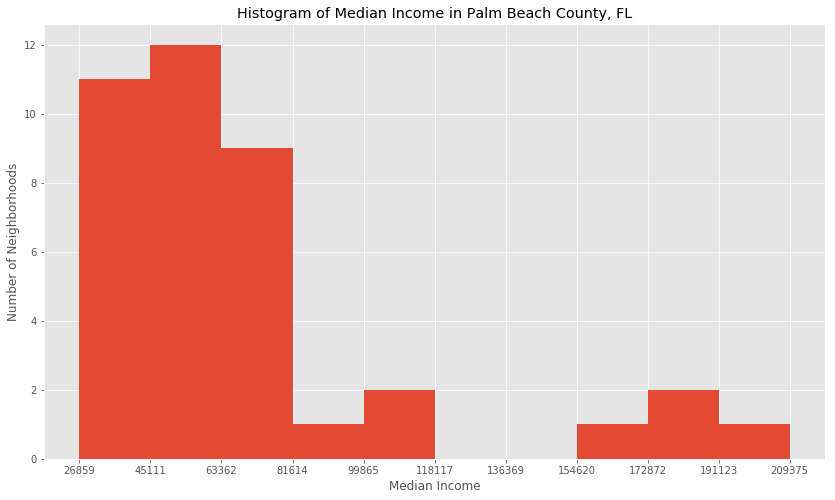

In [168]:
count,bin_edges = py.histogram(df_pbc['Income']) # 'bin_edges' is a list of bin intervals

df_pbc['Income'].plot(kind='hist', figsize=(14, 8),xticks=bin_edges)

plt.title('Histogram of Median Income in Palm Beach County, FL') # Histogram title
plt.ylabel('Number of Neighborhoods') # y-label
plt.xlabel('Median Income') # x-label

plt.show()

#### Median Property Values in Palm Beach County Histogram

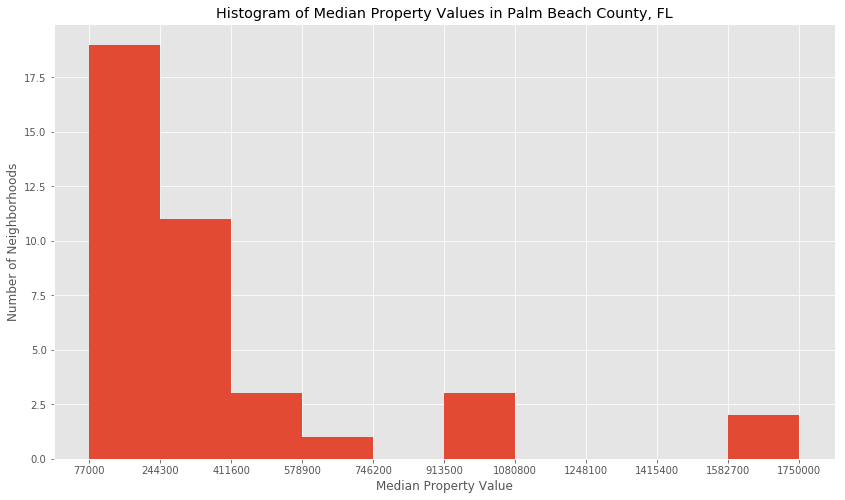

In [169]:
count,bin_edges = py.histogram(df_pbc['Property_Value']) # 'bin_edges' is a list of bin intervals

df_pbc['Property_Value'].plot(kind='hist', figsize=(14, 8),xticks=bin_edges)

plt.title('Histogram of Median Property Values in Palm Beach County, FL') # Histogram title
plt.ylabel('Number of Neighborhoods') # y-label
plt.xlabel('Median Property Value') # x-label

plt.show()

#### Area (in square miles) of Neighborhoods in Palm Beach County Histogram

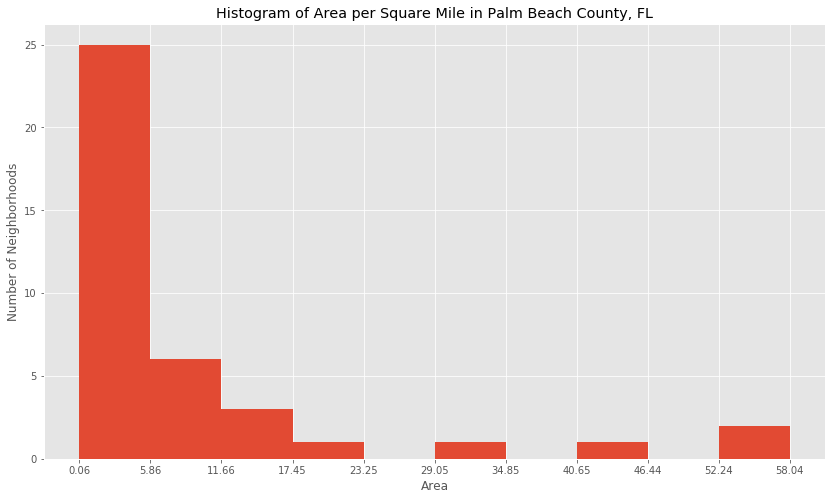

In [171]:
count,bin_edges = py.histogram(df_pbc['Area']) # 'bin_edges' is a list of bin intervals

df_pbc['Area'].plot(kind='hist', figsize=(14, 8),xticks=bin_edges)

plt.title('Histogram of Area per Square Mile in Palm Beach County, FL') # Histogram Title
plt.ylabel('Number of Neighborhoods') # y-label
plt.xlabel('Area') # x-label

plt.show()

#### Population Density in Palm Beach County Histogram

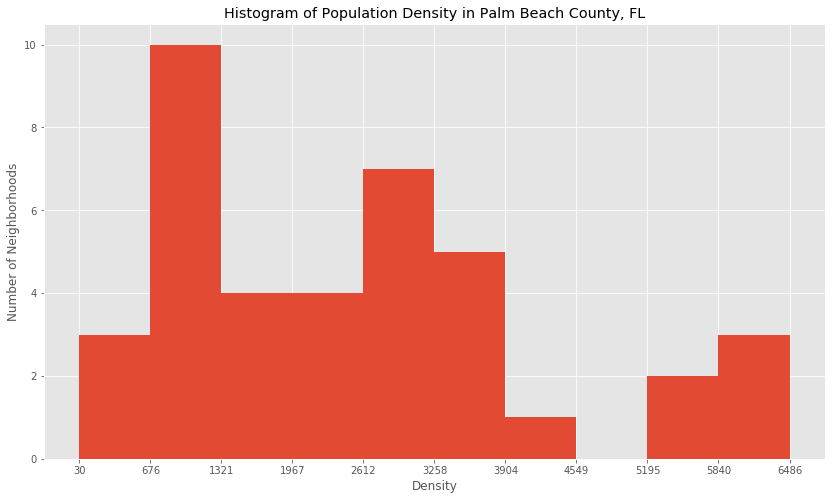

In [172]:
count,bin_edges = py.histogram(df_pbc['Pop_Density']) # 'bin_edges' is a list of bin intervals

df_pbc['Pop_Density'].plot(kind='hist', figsize=(14, 8),xticks=bin_edges)

plt.title('Histogram of Population Density in Palm Beach County, FL') # Histogram Title
plt.ylabel('Number of Neighborhoods') # y-label
plt.xlabel('Density') # x-label

plt.show()

### Plot Bar Charts of Median Income, Median Property Values and Population Density by neighborhood in Palm Beach County
Plot sorted demographics by neighborhood.

#### Median Income for each Neighborhood Bar Chart

First, create a new DataFrame with Median Income indexed by neighborhood. 


In [173]:
df_pbc.head()

,Neighborhood,Latitude,Longitude,Income,Property_Value,Population,Area,Pop_Density
0,Atlantis,26.590902,-80.449417,76641,316100,1883,1.44,1309.45
1,Belle Glade,26.684510,-80.667558,26859,94000,17597,5.71,3079.62
2,Boca Raton,26.358688,-80.083098,68804,418100,87848,31.29,2807.81
3,Boyton Beach,26.525618,-80.066603,53188,206100,70120,16.51,4247.63
4,Briny Breezes,26.509436,-80.054997,38274,147800,702,0.11,6324.32


In [174]:
df_temp = df_pbc.iloc[:,[0,3]] 
df_temp.set_index('Neighborhood', inplace=True)
df_bar = df_temp.sort_values(by = 'Income')
df_bar.head()

,Income
Neighborhood,
Belle Glade,26859
Pahokee,27907
Westgate,28308
South Bay,29405
Mangonia Park,32107


Next, display the bar chart.

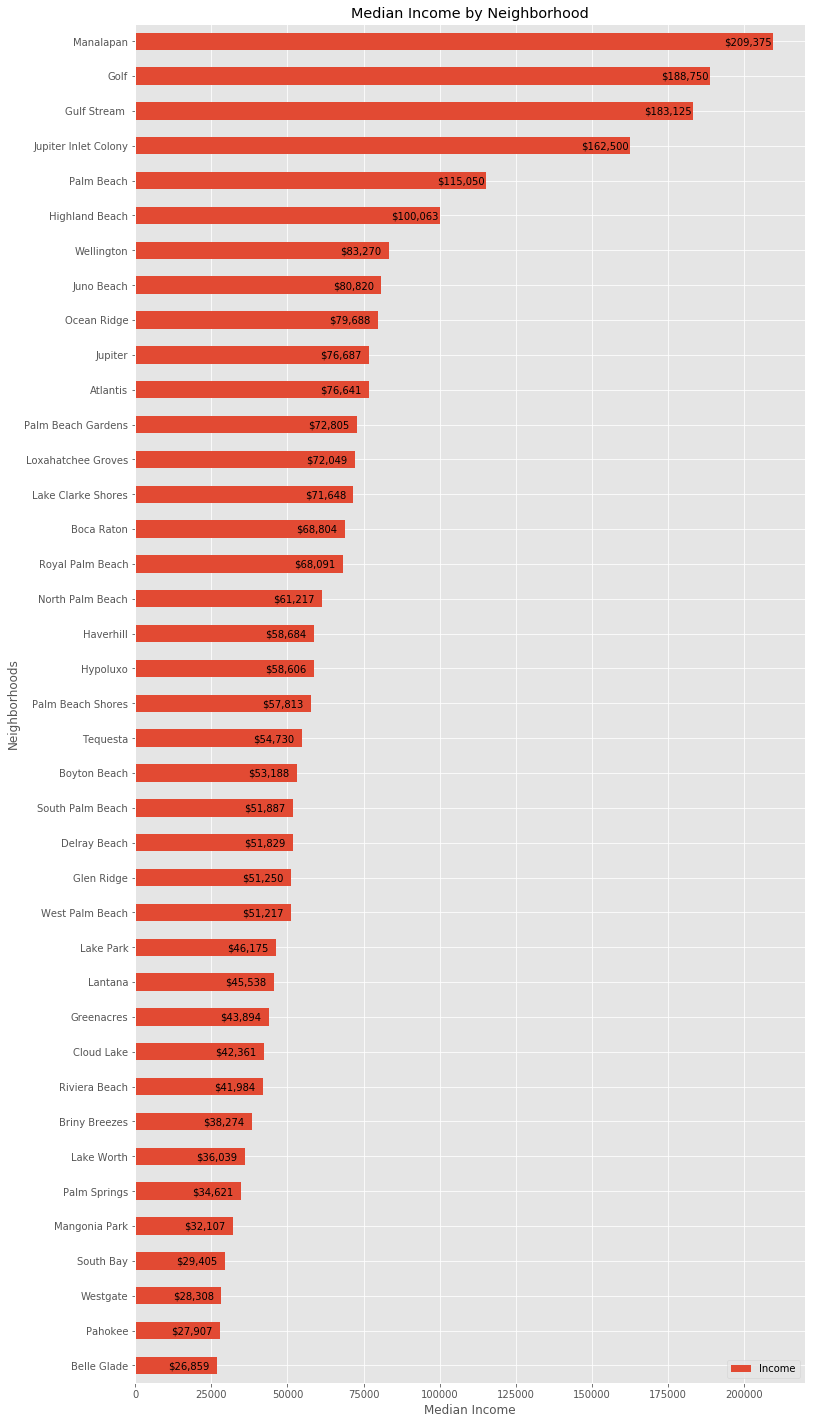

In [175]:
df_bar.plot(kind='barh', figsize=(12, 25))

plt.xlabel('Median Income') # x-label
plt.ylabel('Neighborhoods') # y-label
plt.title('Median Income by Neighborhood') # Bar Chart title

# annotate value labels for each neighborhood
for index, value in enumerate(df_bar.Income): 
    label = '$' + format(int(value), ',') # format income amount with $ and comma
    # place text at the end of bar (subtracting 16000 from x, and 0.1 from y to make it fit within the bar)
    plt.annotate(label, xy=(value - 16000, index - 0.10), color='black')
    
plt.legend(loc='lower right')
plt.show()

#### Median Property Values for each Neighborhood Bar Chart

First, create a new DataFrame with Median Property Value indexed by Neighborhood.

In [11]:
df_temp = df_pbc.iloc[:,[0,4]] 
df_temp.set_index('Neighborhood', inplace=True)
df_bar = df_temp.sort_values(by = 'Property_Value')
df_bar.head()

,Property_Value
Neighborhood,
Pahokee,77000
South Bay,85800
Belle Glade,94000
Palm Springs,96500
Mangonia Park,105200


Next, display the bar chart.

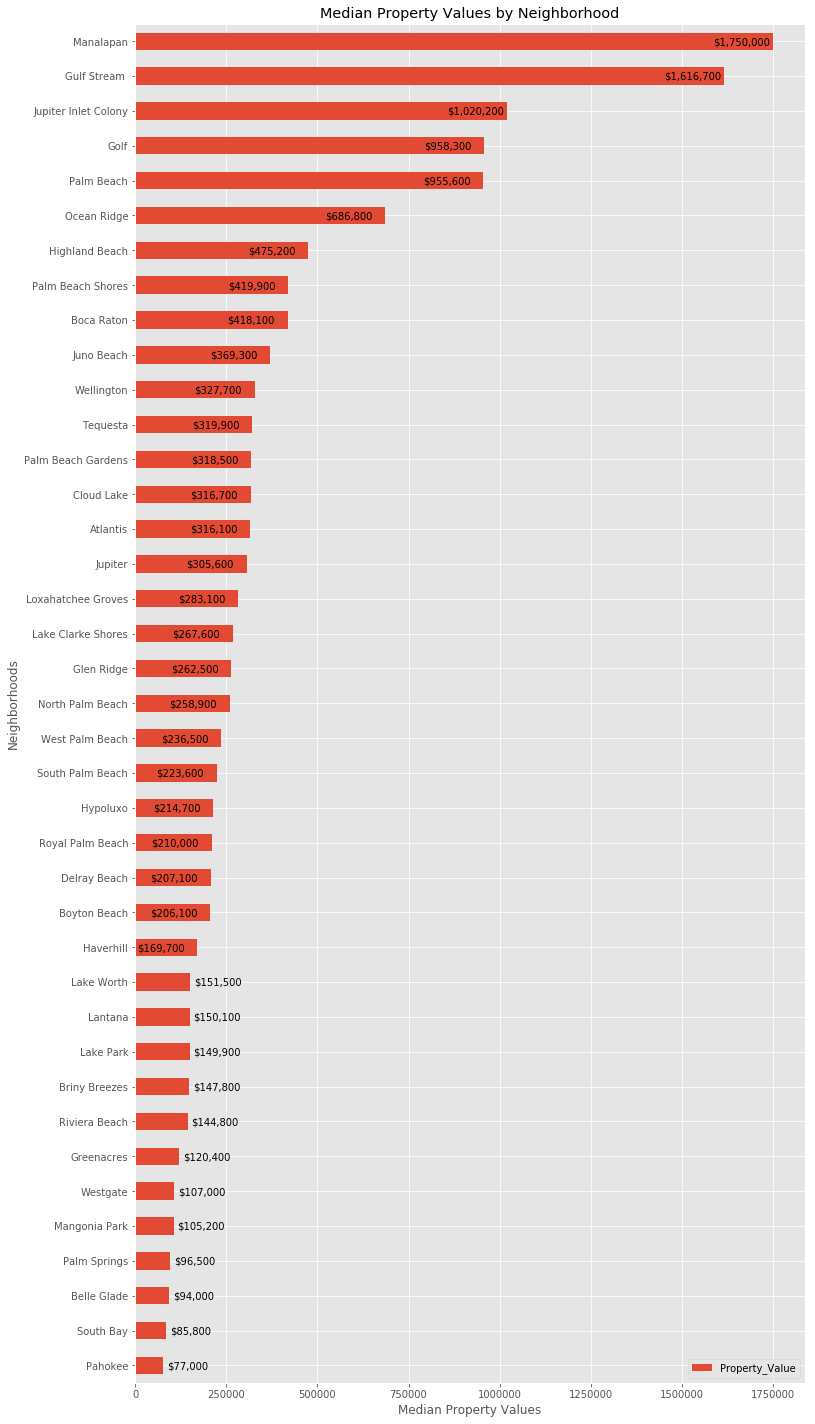

In [12]:
df_bar.plot(kind='barh', figsize=(12, 25))

plt.xlabel('Median Property Values') # x-label
plt.ylabel('Neighborhoods') # y-label
plt.title('Median Property Values by Neighborhood') # Bar Chart title

# annotate value labels for each neighborhood
for index, value in enumerate(df_bar.Property_Value): 
    label = '$' + format(int(value), ',') # format income amount with $ and comma
    # place text at the end of bar (subtracting 165000 from x, and 0.1 from y to make it fit within the bar)
    plt.annotate(label, xy=(value - 165000, index - 0.10), color='black')
    
    # if the bar is too short for the text, display the text next to the bar
    if value < 169000:
         plt.annotate(label, xy=(value + 10000, index - 0.10), color='black')
    
plt.legend(loc='lower right')
plt.show()

In [20]:
df_temp = df_pbc.iloc[:,[0,6]] 
df_temp.set_index('Neighborhood', inplace=True)
df_bar_a = df_temp.sort_values(by = 'Area')
df_bar_a

,Area
Neighborhood,
Cloud Lake,0.06
Briny Breezes,0.11
Jupiter Inlet Colony,0.21
Glen Ridge,0.22
South Palm Beach,0.29
Palm Beach Shores,0.51
Haverhill,0.64
Mangonia Park,0.74
Hypoluxo,0.81


#### Population Density for each Neigborhood Bar Chart

First, create a new DataFrame with Population Density indexed by Neighborhood.

In [176]:
df_temp = df_pbc.iloc[:,[0,7]] 
df_temp.set_index('Neighborhood', inplace=True)
df_bar_p = df_temp.sort_values(by = 'Pop_Density')
df_bar_p.head()

,Pop_Density
Neighborhood,
Manalapan,30.14
Loxahatchee Groves,257.03
Golf,345.60
Palm Beach,766.02
Glen Ridge,888.37


Next, display the bar chart.

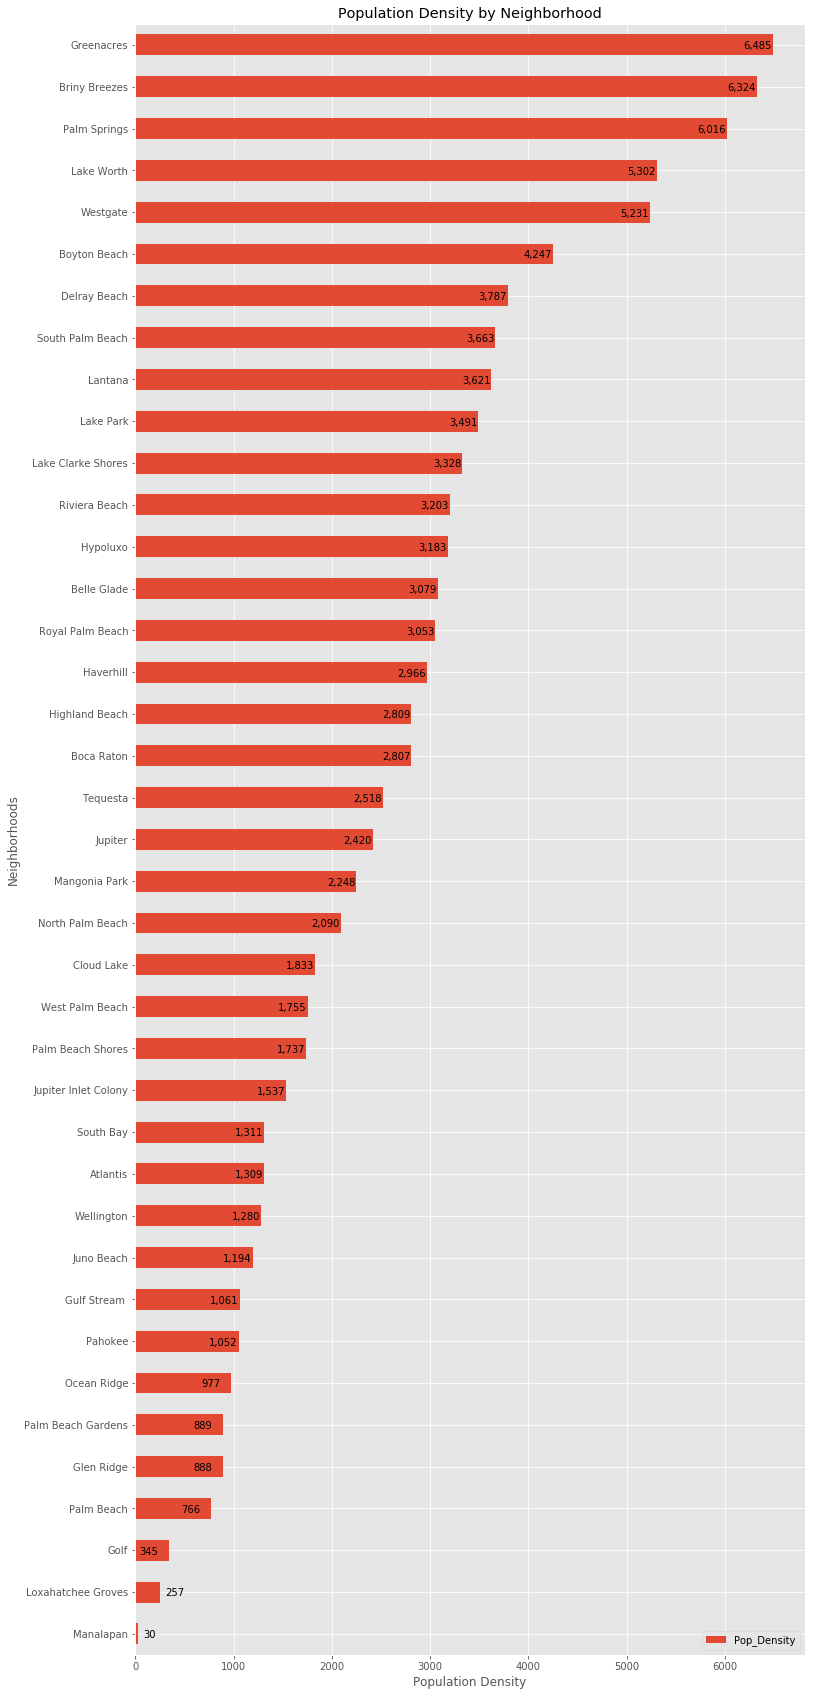

In [177]:
df_bar_p.plot(kind='barh', figsize=(12, 30))

plt.xlabel('Population Density') # x-label
plt.ylabel('Neighborhoods') # y-label
plt.title('Population Density by Neighborhood') # Bar Chart title

# annotate value labels to each country
for index, value in enumerate(df_bar_p.Pop_Density): 
    label = format(int(value), ',') # format int with commas
    
    # place text at the end of bar (subtracting 300 from x, and 0.1 from y to make it fit within the bar)
    plt.annotate(label, xy=(value - 300, index - 0.10), color='black')
    
    # if the bar is too short for the text, display the text next to the bar
    if value < 300:
         plt.annotate(label, xy=(value + 50, index - 0.10), color='black')
    
plt.legend(loc='lower right')
plt.show()

### FOURSQUARE

The FOURSQUARE API is called to retrieve venue data for each neighborhood in order to perform K Nearest Neighbor analysis.<br>

Define credentials and parameters for the FOURSQUARE API call.<br>
NOTE: This cell is hidden.

In [14]:
# The code was removed by Watson Studio for sharing.

Define Parameters - Set limit to the top 100 venues within 1.5 miles for each neighborhood.

In [15]:
# limit of number of venues returned by Foursquare API
limit = 100 

# Determine radius based upon average square miles of all municipalities
pbc_average_sq_area = df_pbc['Area'].mean()
pbc_average_area = math.sqrt(pbc_average_sq_area)
pbc_radius = pbc_average_area / 2

# Convert to meters - 1.52 miles = 2447 meters rounded 
radius = round(1609.344 * pbc_radius)

print(radius) 

2447


This function extracts the venue category from the dictionary returned by the API call.

In [16]:
# All the information is in the items key. 

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

This function sets up the API call and retrieves all venues (up to the limit set above) for all neighborhoods in Palm Beach County.


In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=3320):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhoods', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Call function getNearbyVenues to get venues for each neighborhood.


In [21]:
try:
    pbc_venues = getNearbyVenues(names=df_pbc['Neighborhood'],
                                   latitudes=df_pbc['Latitude'],
                                   longitudes=df_pbc['Longitude']
                                  )
except:
    print ('no group for', Latitude, Longitude)
    
pbc_venues.head()

,Neighborhoods,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Belle Glade,26.68451,-80.667558,Walgreens,26.686691,-80.667077,Pharmacy
1,Belle Glade,26.68451,-80.667558,Banyan Tree,26.697297,-80.683464,Southern / Soul Food Restaurant
2,Belle Glade,26.68451,-80.667558,CVS Pharmacy,26.685225,-80.667529,Pharmacy
3,Belle Glade,26.68451,-80.667558,Wells Fargo Drive-Up Bank,26.685185,-80.668703,Bank
4,Belle Glade,26.68451,-80.667558,United States Postal Service,26.696251,-80.680954,Post Office


Determine how many unique categories can be curated from all the returned venues.

In [22]:
print('There are {} unique categories.'.format(len(pbc_venues['Venue Category'].unique())))

There are 248 unique categories.


Check how many venues were returned for each neighborhood

In [23]:
pbc_venues.groupby('Neighborhoods').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhoods,,,,,,
Belle Glade,26,26,26,26,26,26
Boca Raton,100,100,100,100,100,100
Boyton Beach,100,100,100,100,100,100
Briny Breezes,94,94,94,94,94,94
Cloud Lake,100,100,100,100,100,100
Delray Beach,100,100,100,100,100,100
Glen Ridge,99,99,99,99,99,99
Golf,100,100,100,100,100,100
Greenacres,100,100,100,100,100,100


Dummy-code data for Venue Category column for each neighborhood

In [24]:
# Returns DataFrame pcb_onehot with dummy-coded data for Venue Category column only
pbc_onehot = pd.get_dummies(pbc_venues[['Venue Category']], prefix="", prefix_sep="")

# performed onehot coding on neighborhoods - drop the column
#pbc_onehot.drop(['Neighborhoods'], axis=1)

# add Neighborhoods column to dataframe
pbc_onehot['Neighborhoods'] = pbc_venues['Neighborhoods']
pbc_onehot.head()

,Airport,Airport Gate,Airport Lounge,Airport Service,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Neighborhoods
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Belle Glade
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Belle Glade
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Belle Glade
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Belle Glade
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Belle Glade


Find the position of the 'Neighborhoods' column so it can be placed as the first column of the dataframe

In [25]:
column_position = pbc_onehot.columns.get_loc('Neighborhoods')
print("position: ",column_position )

position:  248


Move neighborhoods column to the first column

In [26]:
# pbc_onehot.columns[position] is the Neighborhoods column
# concatenate the Neighborhoods column with the list of columns before it and after it
fixed_columns = [pbc_onehot.columns[column_position]] + list(pbc_onehot.columns[:column_position]) + list(pbc_onehot.columns[column_position + 1:])

# save the dataframe with the new arrangement of columns
pbc_onehot = pbc_onehot[fixed_columns]
       
pbc_onehot.head()

,Neighborhoods,Airport,Airport Gate,Airport Lounge,Airport Service,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Water Park,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Belle Glade,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Belle Glade,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Belle Glade,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Belle Glade,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Belle Glade,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Get the size of dataframe.

In [27]:
pbc_onehot.shape

(2931, 249)

Group rows by neighborhood and by the frequency of occurrence mean for each category

In [28]:
pbc_grouped = pbc_onehot.groupby('Neighborhoods').mean().reset_index()
pbc_grouped

,Neighborhoods,Airport,Airport Gate,Airport Lounge,Airport Service,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Water Park,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Belle Glade,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
1,Boca Raton,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.01,0.000000,...,0.00,0.000000,0.00,0.01,0.010000,0.000000,0.000000,0.00,0.000000,0.000000
2,Boyton Beach,0.000000,0.000000,0.000000,0.000000,0.060000,0.000000,0.000000,0.00,0.000000,...,0.00,0.000000,0.00,0.00,0.000000,0.020000,0.000000,0.00,0.000000,0.000000
3,Briny Breezes,0.000000,0.000000,0.000000,0.000000,0.063830,0.000000,0.000000,0.00,0.000000,...,0.00,0.000000,0.00,0.00,0.000000,0.010638,0.000000,0.00,0.000000,0.000000
4,Cloud Lake,0.010000,0.010000,0.010000,0.020000,0.060000,0.000000,0.000000,0.00,0.000000,...,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.010000
5,Delray Beach,0.000000,0.000000,0.000000,0.000000,0.040000,0.010000,0.000000,0.00,0.000000,...,0.00,0.000000,0.00,0.00,0.000000,0.010000,0.000000,0.00,0.000000,0.000000
6,Glen Ridge,0.020202,0.010101,0.010101,0.030303,0.050505,0.000000,0.000000,0.00,0.000000,...,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.010101
7,Golf,0.000000,0.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.00,0.000000,...,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
8,Greenacres,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.010000,0.00,0.000000,...,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
9,Gulf Stream,0.000000,0.000000,0.000000,0.000000,0.040000,0.010000,0.000000,0.00,0.000000,...,0.00,0.000000,0.00,0.00,0.000000,0.010000,0.000000,0.00,0.000000,0.000000


Confirm the dataframe size - number of rows equals the number of neighborhoods and number of columns equals the number of categories + 1 (for neighborhood column)

In [29]:
pbc_grouped.shape

(38, 249)

Print each neighborhood along with its top 5 most common venues

In [30]:
num_top_venues = 5

for n in pbc_grouped['Neighborhoods']:
    
    # print the subtitle
    print("----"+n+"----")
    
    # if the neighborhood matches the current neighborhood, save it in temp, transposed, and reset the index
    temp = pbc_grouped[pbc_grouped['Neighborhoods'] == n].T.reset_index()
    
    # add columns venue and freq to temp
    temp.columns = ['venue','freq']
    
    # assign all venues and frequencies to the appropriate columns
    temp = temp.iloc[1:]
    
    # set frequency to float and round to two decimal places
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    
    # sort venues by their frequencies in descending order
    # print only the first 5 venues
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Belle Glade----
                             venue  freq
0             Fast Food Restaurant  0.15
1                         Pharmacy  0.12
2              Fried Chicken Joint  0.08
3  Southern / Soul Food Restaurant  0.08
4                Convenience Store  0.04


----Boca Raton----
              venue  freq
0     Grocery Store  0.04
1       Pizza Place  0.04
2  Sushi Restaurant  0.04
3       Coffee Shop  0.04
4             Hotel  0.04


----Boyton Beach----
                 venue  freq
0                Beach  0.06
1  American Restaurant  0.06
2               Bakery  0.04
3   Seafood Restaurant  0.04
4     Sushi Restaurant  0.03


----Briny Breezes----
                  venue  freq
0                 Beach  0.10
1   American Restaurant  0.06
2  Fast Food Restaurant  0.06
3                  Bank  0.03
4         Deli / Bodega  0.03


----Cloud Lake----
                 venue  freq
0  American Restaurant  0.06
1  Rental Car Location  0.06
2    Convenience Store  0.04
3                Ho

Collect the top venues into a dataframe

This function sorts the venues in descending order and returns the top venues for each neighborhood.

In [31]:
# given each row in a neighborhood, sort by most common venue for num_top_venues
def return_most_common_venues(row, num_top_venues):
    
    # select the venue and frequency from the row
    row_categories = row.iloc[1:]
    
    # sort the frequencies in descending order
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    # return only the top venues
    return row_categories_sorted.index.values[0:num_top_venues]

Determine top ten venues for each neighborhood in order to perform K Nearest Neighbor analysis

In [32]:
# Create the new dataframe and display the top 10 venues for each neighborhood
import numpy as np
num_top_venues = 10

# add 'st', or 'nd', or 'rd' to venue column name - 1st, 2nd, 3rd
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
# First column is Neighborhood
columns = ['Neighborhoods']

# Add columns for 1st through number of top venues
# NumPy arange() is one of the array creation routines based on numerical ranges. 
# It creates an instance of ndarray with evenly spaced values and returns the reference to it.
for ind in np.arange(num_top_venues):
    try:
        # When ind is 0, column is 1st. When ind is 1, column is 2nd. When ind is 2, column is 3rd.
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        # When ind is 3 to num_top_venues, column is ind+1th.
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe with the columns just named
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)

# set the new dataframe Neighborhoods column to that in the pbc_grouped dataframe
neighborhoods_venues_sorted['Neighborhoods'] = pbc_grouped['Neighborhoods']

# for all rows in the pbc_grouped dataframe
# neighborhoods_venues_sorted where rows match ind, and columns 1 to the end is equal to: 
# call return_most_common_venues function with the row equal to ind, and num_top_venues 
for ind in np.arange(pbc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(pbc_grouped.iloc[ind, :], num_top_venues)

# print the new dataframe
neighborhoods_venues_sorted

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Belle Glade,Fast Food Restaurant,Pharmacy,Fried Chicken Joint,Southern / Soul Food Restaurant,Gas Station,Bank,Park,Theater,Donut Shop,Grocery Store
1,Boca Raton,Grocery Store,Bar,Sushi Restaurant,Pizza Place,Coffee Shop,Hotel,Bakery,Italian Restaurant,Mexican Restaurant,Asian Restaurant
2,Boyton Beach,Beach,American Restaurant,Bakery,Seafood Restaurant,Sushi Restaurant,Department Store,Mexican Restaurant,Italian Restaurant,Latin American Restaurant,Burger Joint
3,Briny Breezes,Beach,American Restaurant,Fast Food Restaurant,Seafood Restaurant,Diner,Pizza Place,Deli / Bodega,Donut Shop,Bank,Park
4,Cloud Lake,Rental Car Location,American Restaurant,Diner,Donut Shop,Convenience Store,Hotel,Italian Restaurant,Fast Food Restaurant,Grocery Store,Café
5,Delray Beach,Beach,Italian Restaurant,Grocery Store,Pizza Place,Hotel,American Restaurant,Seafood Restaurant,Coffee Shop,Burger Joint,New American Restaurant
6,Glen Ridge,Rental Car Location,American Restaurant,Donut Shop,Hotel,Diner,Convenience Store,Café,Pharmacy,Fast Food Restaurant,Sandwich Place
7,Golf,American Restaurant,Fast Food Restaurant,Pizza Place,Golf Course,Pharmacy,Donut Shop,Bakery,Grocery Store,Sandwich Place,Department Store
8,Greenacres,Pizza Place,Pharmacy,Discount Store,Convenience Store,Latin American Restaurant,Bank,American Restaurant,Donut Shop,Sandwich Place,Ice Cream Shop
9,Gulf Stream,Beach,Seafood Restaurant,Hotel,American Restaurant,Pizza Place,Diner,Italian Restaurant,Spa,New American Restaurant,Coffee Shop


### K Nearest Neighbor 

K Nearest Neighbor analysis is performed to cluster neighborhoods based upon their shared top venue types.

**Determine the Best K**<br>
First, find the best k by invoking KMeans for 2 to an arbitrary maximum value for k and calculate the squared error.

In [33]:
kMax = 10
cost= [] 

# drop the Neighborhoods column
pbc_grouped_clustering = pbc_grouped.drop('Neighborhoods', 1)

# perform KMeans
for k in range(2,kMax+1):
    kmeans = KMeans(n_clusters = k, random_state=0).fit(pbc_grouped_clustering) 
    # calculates squared error for the clustered points 
    cost.append(kmeans.inertia_)

Then, create a dataframe of cost

In [34]:
value_of_k = [2,3,4,5,6,7,8,9,10]

df_cost = pd.DataFrame(cost,value_of_k)
df_cost

,0
2,0.864097
3,0.730161
4,0.652812
5,0.545395
6,0.450474
7,0.406820
8,0.369423
9,0.335656
10,0.312460


And finally, plot the cost to determine the best value of k. The best value of k is the elbow part of the curve.

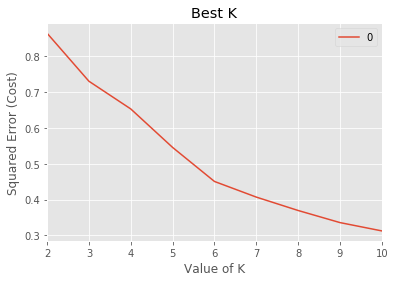

In [35]:
df_cost.plot()

plt.title('Best K')
plt.ylabel('Squared Error (Cost)')
plt.xlabel('Value of K')

plt.show()

**Cluster Neighborhoods by the best K** <br>
Now that the best K is determined, run KMeans for that k.

In [36]:
# Best k is 3
kclusters = 3

# Run k-means to cluster the neighborhoods into 3 clusters.
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(pbc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int32)

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [37]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# df_pbc has latitude and longitude
pbc_merged = df_pbc

# combine df_pbc and neighborhoods_venues_sorted to include venue information and location
pbc_merged = pbc_merged.join(neighborhoods_venues_sorted.set_index('Neighborhoods'), on='Neighborhood')

pbc_merged 

,Neighborhood,Latitude,Longitude,Income,Property_Value,Population,Area,Pop_Density,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Atlantis,26.590902,-80.449417,76641,316100,1883,1.44,1309.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Belle Glade,26.684510,-80.667558,26859,94000,17597,5.71,3079.62,0.0,Fast Food Restaurant,Pharmacy,Fried Chicken Joint,Southern / Soul Food Restaurant,Gas Station,Bank,Park,Theater,Donut Shop,Grocery Store
2,Boca Raton,26.358688,-80.083098,68804,418100,87848,31.29,2807.81,0.0,Grocery Store,Bar,Sushi Restaurant,Pizza Place,Coffee Shop,Hotel,Bakery,Italian Restaurant,Mexican Restaurant,Asian Restaurant
3,Boyton Beach,26.525618,-80.066603,53188,206100,70120,16.51,4247.63,0.0,Beach,American Restaurant,Bakery,Seafood Restaurant,Sushi Restaurant,Department Store,Mexican Restaurant,Italian Restaurant,Latin American Restaurant,Burger Joint
4,Briny Breezes,26.509436,-80.054997,38274,147800,702,0.11,6324.32,0.0,Beach,American Restaurant,Fast Food Restaurant,Seafood Restaurant,Diner,Pizza Place,Deli / Bodega,Donut Shop,Bank,Park
5,Cloud Lake,26.674222,-80.073160,42361,316700,110,0.06,1833.33,0.0,Rental Car Location,American Restaurant,Diner,Donut Shop,Convenience Store,Hotel,Italian Restaurant,Fast Food Restaurant,Grocery Store,Café
6,Delray Beach,26.461462,-80.072820,51829,207100,61553,16.25,3787.64,0.0,Beach,Italian Restaurant,Grocery Store,Pizza Place,Hotel,American Restaurant,Seafood Restaurant,Coffee Shop,Burger Joint,New American Restaurant
7,Glen Ridge,26.669553,-80.073200,51250,262500,191,0.22,888.37,0.0,Rental Car Location,American Restaurant,Donut Shop,Hotel,Diner,Convenience Store,Café,Pharmacy,Fast Food Restaurant,Sandwich Place
8,Golf,26.505999,-80.106022,188750,958300,291,0.84,345.60,0.0,American Restaurant,Fast Food Restaurant,Pizza Place,Golf Course,Pharmacy,Donut Shop,Bakery,Grocery Store,Sandwich Place,Department Store
9,Greenacres,26.629394,-80.136552,43894,120400,38046,5.87,6485.85,0.0,Pizza Place,Pharmacy,Discount Store,Convenience Store,Latin American Restaurant,Bank,American Restaurant,Donut Shop,Sandwich Place,Ice Cream Shop


Drop any rows where the Cluster Labels column is NaN

In [38]:
pbc_merged = pbc_merged.dropna()
pbc_merged

,Neighborhood,Latitude,Longitude,Income,Property_Value,Population,Area,Pop_Density,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Belle Glade,26.684510,-80.667558,26859,94000,17597,5.71,3079.62,0.0,Fast Food Restaurant,Pharmacy,Fried Chicken Joint,Southern / Soul Food Restaurant,Gas Station,Bank,Park,Theater,Donut Shop,Grocery Store
2,Boca Raton,26.358688,-80.083098,68804,418100,87848,31.29,2807.81,0.0,Grocery Store,Bar,Sushi Restaurant,Pizza Place,Coffee Shop,Hotel,Bakery,Italian Restaurant,Mexican Restaurant,Asian Restaurant
3,Boyton Beach,26.525618,-80.066603,53188,206100,70120,16.51,4247.63,0.0,Beach,American Restaurant,Bakery,Seafood Restaurant,Sushi Restaurant,Department Store,Mexican Restaurant,Italian Restaurant,Latin American Restaurant,Burger Joint
4,Briny Breezes,26.509436,-80.054997,38274,147800,702,0.11,6324.32,0.0,Beach,American Restaurant,Fast Food Restaurant,Seafood Restaurant,Diner,Pizza Place,Deli / Bodega,Donut Shop,Bank,Park
5,Cloud Lake,26.674222,-80.073160,42361,316700,110,0.06,1833.33,0.0,Rental Car Location,American Restaurant,Diner,Donut Shop,Convenience Store,Hotel,Italian Restaurant,Fast Food Restaurant,Grocery Store,Café
6,Delray Beach,26.461462,-80.072820,51829,207100,61553,16.25,3787.64,0.0,Beach,Italian Restaurant,Grocery Store,Pizza Place,Hotel,American Restaurant,Seafood Restaurant,Coffee Shop,Burger Joint,New American Restaurant
7,Glen Ridge,26.669553,-80.073200,51250,262500,191,0.22,888.37,0.0,Rental Car Location,American Restaurant,Donut Shop,Hotel,Diner,Convenience Store,Café,Pharmacy,Fast Food Restaurant,Sandwich Place
8,Golf,26.505999,-80.106022,188750,958300,291,0.84,345.60,0.0,American Restaurant,Fast Food Restaurant,Pizza Place,Golf Course,Pharmacy,Donut Shop,Bakery,Grocery Store,Sandwich Place,Department Store
9,Greenacres,26.629394,-80.136552,43894,120400,38046,5.87,6485.85,0.0,Pizza Place,Pharmacy,Discount Store,Convenience Store,Latin American Restaurant,Bank,American Restaurant,Donut Shop,Sandwich Place,Ice Cream Shop
10,Gulf Stream,26.488762,-80.058349,183125,1616700,876,0.83,1061.81,0.0,Beach,Seafood Restaurant,Hotel,American Restaurant,Pizza Place,Diner,Italian Restaurant,Spa,New American Restaurant,Coffee Shop


Visualize the clusters with a folium map.

In [50]:
# create the map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(pbc_merged['Latitude'], pbc_merged['Longitude'], pbc_merged['Neighborhood'], pbc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

Display the top 10 venues for each neighborhood within each cluster and determine the cluster defining characteristics.

**CLUSTER 0** - Residential - with a variety of restaurants and other eateries

In [42]:
# Cluster 0
pbc_merged.loc[pbc_merged['Cluster Labels'] == 0, pbc_merged.columns[[0] + list(range(7, pbc_merged.shape[1]))]]

,Neighborhood,Pop_Density,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Belle Glade,3079.62,0.0,Fast Food Restaurant,Pharmacy,Fried Chicken Joint,Southern / Soul Food Restaurant,Gas Station,Bank,Park,Theater,Donut Shop,Grocery Store
2,Boca Raton,2807.81,0.0,Grocery Store,Bar,Sushi Restaurant,Pizza Place,Coffee Shop,Hotel,Bakery,Italian Restaurant,Mexican Restaurant,Asian Restaurant
3,Boyton Beach,4247.63,0.0,Beach,American Restaurant,Bakery,Seafood Restaurant,Sushi Restaurant,Department Store,Mexican Restaurant,Italian Restaurant,Latin American Restaurant,Burger Joint
4,Briny Breezes,6324.32,0.0,Beach,American Restaurant,Fast Food Restaurant,Seafood Restaurant,Diner,Pizza Place,Deli / Bodega,Donut Shop,Bank,Park
5,Cloud Lake,1833.33,0.0,Rental Car Location,American Restaurant,Diner,Donut Shop,Convenience Store,Hotel,Italian Restaurant,Fast Food Restaurant,Grocery Store,Café
6,Delray Beach,3787.64,0.0,Beach,Italian Restaurant,Grocery Store,Pizza Place,Hotel,American Restaurant,Seafood Restaurant,Coffee Shop,Burger Joint,New American Restaurant
7,Glen Ridge,888.37,0.0,Rental Car Location,American Restaurant,Donut Shop,Hotel,Diner,Convenience Store,Café,Pharmacy,Fast Food Restaurant,Sandwich Place
8,Golf,345.60,0.0,American Restaurant,Fast Food Restaurant,Pizza Place,Golf Course,Pharmacy,Donut Shop,Bakery,Grocery Store,Sandwich Place,Department Store
9,Greenacres,6485.85,0.0,Pizza Place,Pharmacy,Discount Store,Convenience Store,Latin American Restaurant,Bank,American Restaurant,Donut Shop,Sandwich Place,Ice Cream Shop
10,Gulf Stream,1061.81,0.0,Beach,Seafood Restaurant,Hotel,American Restaurant,Pizza Place,Diner,Italian Restaurant,Spa,New American Restaurant,Coffee Shop


**CLUSTER 1** - Outdoor leisure activities - golfing, camping, boating - and parks

In [43]:
# Cluster 1 
pbc_merged.loc[pbc_merged['Cluster Labels'] == 1, pbc_merged.columns[[0] + list(range(7, pbc_merged.shape[1]))]]

,Neighborhood,Pop_Density,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,Tequesta,2518.66,1.0,Golf Course,Campground,River,Baseball Field,Trail,Home Service,Science Museum,Church,Park,Dive Bar


In [ ]:
**CLUSTER 2** - Food and Business

In [44]:
# Cluster 2
pbc_merged.loc[pbc_merged['Cluster Labels'] == 2, pbc_merged.columns[[0] + list(range(7, pbc_merged.shape[1]))]]

,Neighborhood,Pop_Density,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Palm Beach,766.02,2.0,Business Service,Zoo,Fast Food Restaurant,Fruit & Vegetable Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop


***

## Results <a name="results"></a>

### Histograms and Bar Charts
**Median Income** The histogram of Median Income shows three groups. <br>
- The group with the most neighborhoods, 32 neighborhoods, has the lowest median income level of about 27,000 USD to 81,000 USD.<br>

The remaining neighborhoods are split between medium and high median income levels with the second group of only 3 neighborhoods, 
and the third group of only 4 neighborhoods. <br>
- The second group with medium median income includes the neighborhoods Wellington (about 83,000 USD), Highland Beach (about 100,000 USD), and Palm Beach (about 115,000 USD).<br> 
- The third group with the highest median income includes Jupiter Inlet Colony (about 163,000 USD), Gulf Stream (about 183,000 USD), Golf (about 189,000 USD), and Manalapan 
(about 209,000 USD). 

**Median Property Values** The histogram of Median Property Values shows four groups.<br> 
- The group with the most neighborhoods, 28 neighborhoods, has the lowest median property values which range from 77,000 USD to 370,000 USD. <br>
- The second group of 4 neighborhoods – Boca Raton, Palm Beach Shores, Highland Beach, and Ocean Ridge – have median property values between 418,000 USD and $687,000 USD. <br>
- The third group comprising 3 neighborhoods – Palm Beach, Golf, and Jupiter Inlet – have median property values from about 956,000 to about 1.1 million USD. <br>
- And the fourth group of 2 neighborhoods – Gulf Stream and Manalapan - have median property values over 1.6 million USD.  

**Population Density** The histogram of Population Density shows three groups.<br>
- The three neighborhoods with the lowest population density are Manalapan, Loxahatchee Groves, and Golf. <br>
- Most neighborhoods fall within the medium density range, and <br>
- The neighborhoods with the highest population density are Westgate, Lake Worth, Palm Springs, Briny Breezes, and Greenacres.

**Area** The histogram of Area shows there are four major neighborhoods in terms of square mile area. <br> 
- The first group includes most neighborhoods, 35. Most of these neighborhoods are very small; 25 neigborhoods are under 6 square miles while the other small neighborhoods are under about 23 square miles.<br> 
- One neighborhood, Boca Raton, is of medium size or about 31 square miles. <br> 
- One neighborhood is larger, Wellington, at about 45 square miles, and <br>
- Two are largest, Palm Beach Gardens and West Palm Beach at about 55 square miles and 58 square miles, respectively.

### KMeans

The best value for K is three according to the calculation of cost or squared error when plotted. <br><br>The three clusters are:<br>
**Cluster 0** includes all neighborhoods except for the two that are Clusters 1 and 2. Cluster 0 is characterized as residential with a wide variety of restaurants and other eateries as well as grocery stores. Banks and beaches venues are also included.<br>
**Cluster 1** includes only the municipality of Tequesta. This cluster is characterized by outdoor leisure activities like golfing, camping, boating, and baseball. Also included are science museum, church, and parks.<br>
**Cluster 2** includes only the municipality of Palm Beach. This cluster is characterized by business services, zoo, and eateries.<br><br>
Venues were not retrieved for the municipality of Atlantis; and therefore, was not included in a cluster.

***

## Discussion <a name="discussion"></a>

Palm Beach County is diverse in terms of income levels, and property values. Palm Beach County median income ranges from below the national average 
of 57,617 USD to well above it. Similarly, Palm Beach County median property values ranges from below the national average of 205,000 USD to well 
above it. As a result, Palm Beach County offers home affordability for all income levels.<br><br>
Most municipalities are relatively small in terms of area in square miles. And, most of Palm Beach County has a higher population density than the 
national average of 92.9 residents per square mile of land area. <br><br>
According to K Means, Palm Beach County can be segregated into three main clusters. Two of these clusters have only one municipality 
(Tequesta, and Palm Beach), and the third cluster has the rest of the municipalities.<br><br>
Tequesta (Cluster 0) is the northernmost municipality in Palm Beach County, situated between the Atlantic Ocean and the Loxahatchee River, with an 
active recreational department, lots of golf courses, and many campgrounds.<br><br>
Palm Beach (Cluster 1) is an island centrally located in Palm Beach County with the Atlantic Ocean to the east and the Intracoastal Waterway to the west. 
It is just across the waterway to West Palm Beach; and as such, the venues cited are more related to West Palm Beach than Palm Beach. 
For example, zoo is the second most common venue, but there is not a zoo on Palm Beach; rather, it is in West Palm Beach. 
In addition, fast food restaurants, the third most common venue are also not found on Palm Beach. 
Palm Beach is mostly residential and home to the wealthy and upscale dining and shopping. Notable examples are Mar-a-Lago and Worth Avenue.<br><br>
The third cluster (Cluster 2) groups municipalities that are inland with those that are on the coast. Inland municipalities are mainly residential whereas 
coastline municipalities, while also residential, contribute to Florida’s tourism economy with their beaches and hotels. 
The most popular venues in this cluster are restaurants, grocery stores, and banks. <br><br>
The clustering is skewed by COVID-19. Although Florida was one of the first states to open from the lockdown, people mainly patronize grocery stores, 
and banks as well as restaurants and other eateries, and the beach. The tourist industry in Florida has greatly suffered as people are not 
traveling in general, and specifically to Florida. Once the economy has recovered, the K Means clustering should be more representative of Palm Beach County municipalities.

***

## Conclusion <a name="conclusion"></a>

This project is meant to give active seniors who plan to relocate an overview of Palm Beach County, Florida information that will help them 
determine which areas they should explore. The data shows that Palm Beach County allows affordability to a wide range of incomes and desired 
property values. According to K Means, the county is fairly homogeneous in terms of the most common venues which center around grocery stores, 
restaurants, banks, and beaches. Because of COVID-19, I believe the data is skewed. Although the state has opened, people are not yet shopping, 
and taking part in activities as they were before the onset of the pandemic. Also, the tourist industry has suffered greatly since people are 
not traveling. Once life gets back to normal, the clustering data will be more helpful.

***